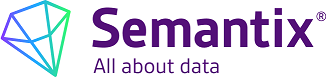

<h3>Projeto Final de Spark - Nível Básico</h3>

**Campanha Nacional de Vacinação contra Covid-19**: [Dados](https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar) e [Referência das Visualizações](https://covid.saude.gov.br/)

Aluna: Danielle Calazans Dondoni

#### Descrição das fórmulas que serão utilizadas para obter os dados do painel

- <span style='color:Blue'> Coeficiente de Incidência: </span> Número de casos confirmados de COVID-19, por 100 mil habitantes, na população residente em determinado espaço geográfico, no período considerado. 

- <span style='color:Blue'> Coeficiente de Mortalidade:</span> Número de óbitos por doenças COVID-19, por 100 mil habitantes, na população residente em determinado espaço geográfico, no período considerado.

- <span style='color:Blue'>Taxa de Letalidade:</span> Número de óbitos confirmados de COVID-19 em relação ao total de casos confirmados, na população residente em determinado espaço geográfico, no período considerado.

In [1]:
# Importação dos pacotes necessários

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

### 1 - Enviar os dados para o hdfs

Etapa realizada no terminal.

Passo a passo detalhado neste breve tutorial: [AQUI](https://github.com/daniellecd/projeto_semantix/blob/main/Ambiente%20de%20Desenvolvimento.md)

In [2]:
# Listagem dos arquivos presentes no hdfs

!hdfs dfs -ls -R /user/danielle/covid

-rw-r--r--   3 root supergroup   62492959 2021-07-13 22:00 /user/danielle/covid/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup   76520681 2021-07-13 22:00 /user/danielle/covid/HIST_PAINEL_COVIDBR_2020_Parte2_06jul2021.csv
-rw-r--r--   3 root supergroup   91120916 2021-07-13 22:00 /user/danielle/covid/HIST_PAINEL_COVIDBR_2021_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup    3046774 2021-07-13 22:01 /user/danielle/covid/HIST_PAINEL_COVIDBR_2021_Parte2_06jul2021.csv


In [3]:
# Leitura dos dados e visualizaçõs do schema

df = spark.read.csv("/user/danielle/covid/*.csv", sep =';', header = True, inferSchema = True)
df.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: timestamp (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: decimal(10,0) (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)



In [4]:
# Ajuste do tipo dos dados - Informações são diárias, não necessita do campo hora

df = df.withColumn('data', f.from_unixtime(f.unix_timestamp(df.data), "yyyy-MM-dd"))
df = df.withColumn("obitosAcumulado", col("obitosAcumulado").cast(IntegerType()))

In [5]:
# Visualização de quatro colunas da tabela dados

df.select('data','regiao','casosNovos','casosAcumulado').show(10, truncate = False)

+----------+------+----------+--------------+
|data      |regiao|casosNovos|casosAcumulado|
+----------+------+----------+--------------+
|2020-02-25|Brasil|0         |0             |
|2020-02-26|Brasil|1         |1             |
|2020-02-27|Brasil|0         |1             |
|2020-02-28|Brasil|0         |1             |
|2020-02-29|Brasil|1         |2             |
|2020-03-01|Brasil|0         |2             |
|2020-03-02|Brasil|0         |2             |
|2020-03-03|Brasil|0         |2             |
|2020-03-04|Brasil|1         |3             |
|2020-03-05|Brasil|4         |7             |
+----------+------+----------+--------------+
only showing top 10 rows



### 2 - Otimizar todos os dados do hdfs para uma tabela Hive particionada por município

In [ ]:
# Salvando os dados em tabela Hive particionada por município

df.write.mode('overwrite').partitionBy('municipio').saveAsTable('danielle.projeto')

In [6]:
# Identificação da tabela Hive criada

!hdfs dfs -ls /user/hive/warehouse/danielle.db

Found 1 items
drwxr-xr-x   - root supergroup          0 2021-07-18 03:04 /user/hive/warehouse/danielle.db/projeto


In [7]:
# Visualização das partições criadas - apenas as 10 primeiras em ordem alfabética

spark.sql('show partitions danielle.projeto').show(10, truncate = False)

+-----------------------------+
|partition                    |
+-----------------------------+
|municipio=Abadia de Goiás    |
|municipio=Abadia dos Dourados|
|municipio=Abadiânia          |
|municipio=Abaetetuba         |
|municipio=Abaeté             |
|municipio=Abaiara            |
|municipio=Abaré              |
|municipio=Abatiá             |
|municipio=Abaíra             |
|municipio=Abdon Batista      |
+-----------------------------+
only showing top 10 rows



 ### 3 - Criar as 3 visualizações pelo Spark com os dados enviados para o HDFS

<span style='color:Purple'> **PAINEL 1 - Casos Recuperados**</span>

In [8]:
# Os dados estão atualizados até o dia 06/07/2021

data = "2021-07-06"
br = df.where((df.regiao == 'Brasil') & (df.data == data))

In [9]:
# Número de casos recuperados e em acompanhamento - nível nacional (06/07/2021)

recuperados_br = br.select(br['regiao'].alias('Região'),\
                           br['Recuperadosnovos'].alias('Casos_Recuperados'),\
                           br['emAcompanhamentoNovos'].alias('Em_Acompanhamento'))
recuperados_br.show()

+------+-----------------+-----------------+
|Região|Casos_Recuperados|Em_Acompanhamento|
+------+-----------------+-----------------+
|Brasil|         17262646|          1065477|
+------+-----------------+-----------------+



<span style='color:Purple'> **PAINEL 2 - Casos Confirmados** </span>

In [10]:
# Número de casos acumulados, casos novos e incidência - nível nacional (06/07/2021)

casos_br = br.select(br['regiao'].alias('Região'),\
                     br['casosAcumulado'].alias('Casos_Acumulados'),\
                     br['casosNovos'].alias('Casos_Novos'),\
                    (f.round(br['casosAcumulado']/br['populacaoTCU2019']*100000,1)).alias('Incidência'))
casos_br.show()

+------+----------------+-----------+----------+
|Região|Casos_Acumulados|Casos_Novos|Incidência|
+------+----------------+-----------+----------+
|Brasil|        18855015|      62504|    8972.3|
+------+----------------+-----------+----------+



<span style='color:Purple'> **PAINEL 3 - Óbitos Confirmados** </span>

In [11]:
# Número de óbitos acumulados, óbitos novos, letalidade e mortalidade - nível nacional (06/07/2021)

obitos_br = br.select(br['regiao'].alias('Região'),\
                      br['obitosAcumulado'].alias('Óbitos_Acumulados'),\
                      br['obitosNovos'].alias('Óbitos_Novos'),\
                     (f.round(br['obitosAcumulado']/br['casosAcumulado']*100,1)).alias('Letalidade'),\
                     (f.round(br['obitosAcumulado']/br['populacaoTCU2019']*100000,1)).alias('Mortalidade'))
obitos_br.show()

+------+-----------------+------------+----------+-----------+
|Região|Óbitos_Acumulados|Óbitos_Novos|Letalidade|Mortalidade|
+------+-----------------+------------+----------+-----------+
|Brasil|           526892|        1780|       2.8|      250.7|
+------+-----------------+------------+----------+-----------+



### 4 - Salvar a primeira visualização como tabela Hive.

In [12]:
# Criação e identificação da tabela Hive com os dados do primeiro painel
# Por padrão o método save() salva no formato parquet e compressão snappy

recuperados_br.write.mode('overwrite').saveAsTable('recuperados_br_covid')
!hdfs dfs -ls /user/hive/warehouse/recuperados_br_covid

Found 3 items
-rw-r--r--   2 root supergroup          0 2021-07-18 23:14 /user/hive/warehouse/recuperados_br_covid/_SUCCESS
-rw-r--r--   2 root supergroup        483 2021-07-18 23:14 /user/hive/warehouse/recuperados_br_covid/part-00000-8953201c-6168-4d7d-9442-fe400325d2e3-c000.snappy.parquet
-rw-r--r--   2 root supergroup        917 2021-07-18 23:14 /user/hive/warehouse/recuperados_br_covid/part-00003-8953201c-6168-4d7d-9442-fe400325d2e3-c000.snappy.parquet


### 5 - Salvar a segunda visualização com formato parquet e compressão snappy.

In [13]:
# Criação e identificação da tabela Hive com os dados do segundo painel
# Por padrão o método save() salva no formato parquet e compressão snappy

casos_br.write.mode('overwrite').save('/user/danielle/casos_br_covid')
!hdfs dfs -ls /user/danielle/casos_br_covid

Found 3 items
-rw-r--r--   2 root supergroup          0 2021-07-18 23:14 /user/danielle/casos_br_covid/_SUCCESS
-rw-r--r--   2 root supergroup        586 2021-07-18 23:14 /user/danielle/casos_br_covid/part-00000-50685cea-5433-4a9b-96e8-ce073e14d31c-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1257 2021-07-18 23:14 /user/danielle/casos_br_covid/part-00003-50685cea-5433-4a9b-96e8-ce073e14d31c-c000.snappy.parquet


### 6 - Salvar a terceira visualização em um tópico no Kafka.

In [14]:
# Criação de um tópico no kafka com os dados do terceiro painel
# As colunas serão transformadas em um json para enviar todos os dados em um unico tópico

obitos_br\
    .selectExpr("to_json(struct(*)) AS value")\
    .write\
    .format('kafka')\
    .option('kafka.bootstrap.servers', 'kafka:9092')\
    .option('topic', 'obitos_brasil')\
    .save()

In [15]:
# Para conferir a criação do tópico, realizamos a leitura dele

obitos_topic = spark.read\
    .format('kafka')\
    .option('kafka.bootstrap.servers', 'kafka:9092')\
    .option('subscribe','obitos_brasil') \
    .load()

topic_string = obitos_topic.select(col('value').cast('string'))
topic_string.show(truncate = False)

+-------------------------------------------------------------------------------------------------------+
|value                                                                                                  |
+-------------------------------------------------------------------------------------------------------+
|{"Região":"Brasil","Óbitos_Acumulados":526892,"Óbitos_Novos":1780,"Letalidade":2.8,"Mortalidade":250.7}|
+-------------------------------------------------------------------------------------------------------+



### 7 - Criar a visualização pelo Spark com os dados enviados para o HDFS.

<span style='color:Purple'> **PAINEL 4 - Síntese de casos, óbitos, incidência e mortalidade** </span>

In [16]:
# Número de casos acumulados, óbitos acumulados, incidência e mortalidade - nível regional (06/07/2021)

sintese = df.groupBy(['regiao', 'estado'])\
            .agg({'casosAcumulado':'max', 'obitosAcumulado':'max', 'populacaoTCU2019':'max'})

sintese = (sintese
       .withColumnRenamed('max(populacaoTCU2019)','População')
       .withColumnRenamed('max(casosAcumulado)', 'Casos_Acumulados')
       .withColumnRenamed('max(obitosAcumulado)','Óbitos_Acumulados'))

sintese = (sintese
           .withColumn('Incidência', f.round(sintese['Casos_Acumulados']/sintese['População']*100000,1))
           .withColumn('Mortalidade', f.round(sintese['Óbitos_Acumulados']/sintese['População']*100000,1)))
                             
                             
sintese.drop('População').sort(col('regiao').asc()).show(30)

+------------+------+----------------+-----------------+----------+-----------+
|      regiao|estado|Casos_Acumulados|Óbitos_Acumulados|Incidência|Mortalidade|
+------------+------+----------------+-----------------+----------+-----------+
|      Brasil|  null|        18855015|           526892|    8972.3|      250.7|
|Centro-Oeste|    GO|          686433|            19485|    9780.5|      277.6|
|Centro-Oeste|    DF|          434708|             9322|   14416.9|      309.2|
|Centro-Oeste|    MS|          339323|             8400|   12210.3|      302.3|
|Centro-Oeste|    MT|          456155|            12000|   13091.1|      344.4|
|    Nordeste|    MA|          322052|             9190|    4551.9|      129.9|
|    Nordeste|    PI|          299084|             6662|    9137.3|      203.5|
|    Nordeste|    PB|          402175|             8724|   10009.0|      217.1|
|    Nordeste|    PE|          561505|            17953|    5875.3|      187.9|
|    Nordeste|    BA|         1141612|  

### 8 - Salvar a visualização do exercício 6 em um tópico no Elastic.

In [17]:
# Instalação do pacote necessário

!pip install elasticsearch

Não esquecer de verificar se o conector ES-Hadoop está instalado. Acessar http://localhost:4040/environment/ e na seção Classpath Entries verificar a presença do jar /opt/spark/jars/elasticsearch-hadoop-7.9.2.jar

In [18]:
from elasticsearch import Elasticsearch

# Configurando a conexão com o Elastic
es = Elasticsearch('host.docker.internal:9200')

# Verificando a configuração do Elastichsearch
es.info(pretty=True)

{'name': 'node1',
 'cluster_name': 'my_cluster',
 'cluster_uuid': 'IZubO8f9R5GaDYME2tnfZw',
 'version': {'number': '7.9.2',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [19]:
# A visualização do exercício 6 é o terceito painel, com dataframe de nome obitos_br
# Transformando o tipo da coluna para float

obitos_br = obitos_br.withColumn("Letalidade", col("Letalidade").cast(FloatType()))\
                     .withColumn("Mortalidade", col("Mortalidade").cast(FloatType()))

In [20]:
# Enviando os dados para o Elastic

obitos_br.write.format("org.elasticsearch.spark.sql") \
                .option("es.nodes", "host.docker.internal") \
                .option("es.port", '9200')\
                .option("es.resource", 'br_dashboard/sample') \
                .option("es.nodes.wan.only", "true") \
                .mode('overwrite')\
                .save()

In [21]:
# Verificando os dados no Elastic

es.search(index="br_dashboard")

{'took': 0,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'br_dashboard',
    '_type': 'sample',
    '_id': 'B8Xou3oB5NJPXsQ5LRa7',
    '_score': 1.0,
    '_source': {'Região': 'Brasil',
     'Óbitos_Acumulados': 526892,
     'Óbitos_Novos': 1780,
     'Letalidade': 2.8,
     'Mortalidade': 250.7}}]}}

### 9 - Criar um dashboard no Elastic para visualização dos novos dados enviados.

O dashboard é simples, visto que a origem dos dados contém pouca informação.

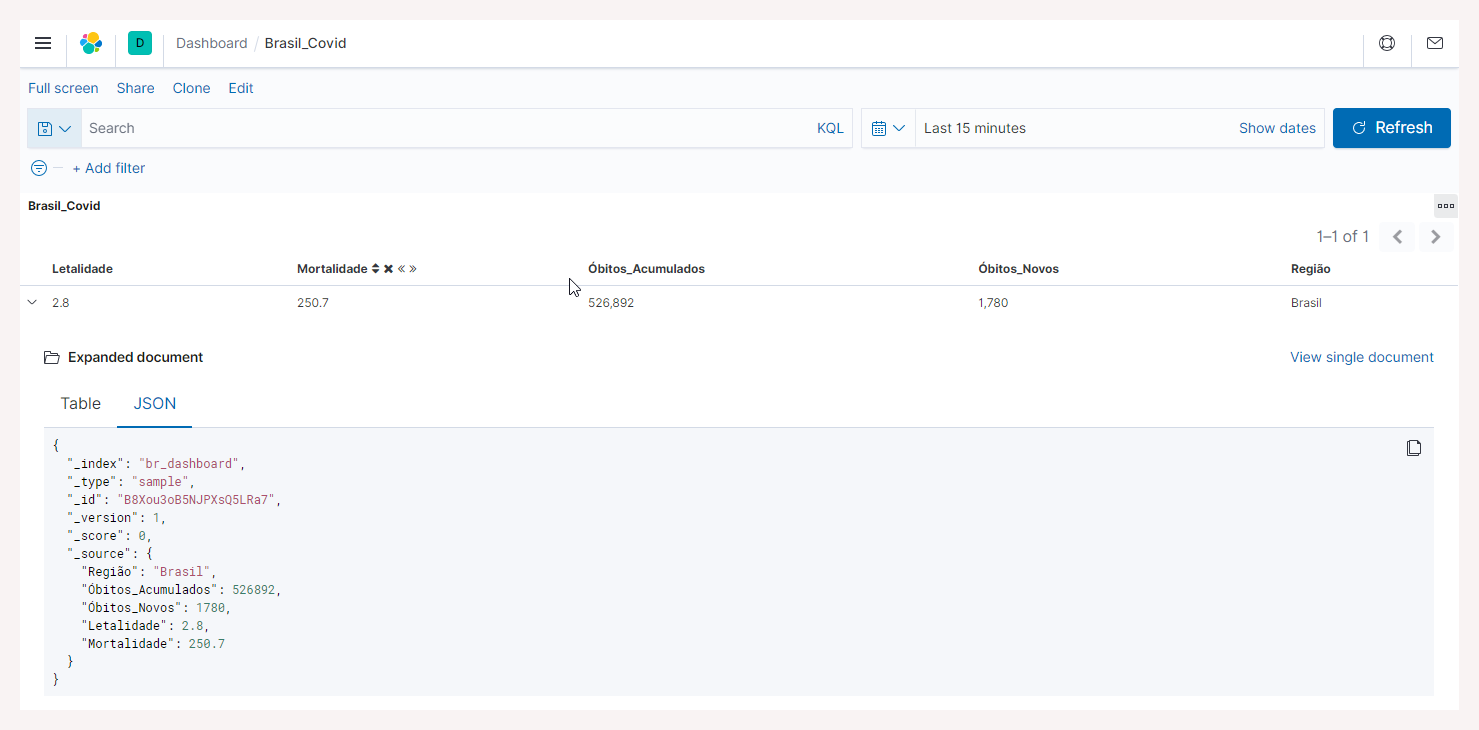